Lab 3: Deep embeddings for image recognition
=====

We are going to train algorithms to detect the presence/absence of a single target species, using two different approaches:    
(a) training an algorithm directly on the images;     
(b) extracting "embeddings" from MegaDetector (a CNN wildlife detector) and training an algorithm on those.

============================

Lab 3a: Image data preparation
----------

Again we'll use the dataset **parakeetsNL400images** here (112MB): https://surfdrive.surf.nl/files/index.php/s/BzKBh8jDUagEEAV Download it if you don't have it.

The dataset has two folders: positive and negative images. Positive images are the rose-ringed parakeets we've already seen, and negative images are also parakeets but other species (not "rose-ringed" ones) spotted in the Netherlands:    
Psittacula eupatria ("Alexandrine Parakeet")    
Psittacula cyanocephala ("Plum-headed parakeet")    
Psittacula derbiana ("Derby's parakeet")

Once you have downloaded the two different sets you should have two folders:

* parakeetsNL_roseringed_images200   (the positive class)
* parakeetsNL_otherspecies_images200   (the negative class)

Write code to summarise the number of files you have in these two folders.
Write code to open one image file (using skimage) and print the size of the image tensor you have loaded (in numpy, this is the "shape").

What do each of the axes correspond to?

number of roseringed parakeet images: 189
number of other parakeet images: 178
shape of numype tensor of the image : (800, 533, 3)


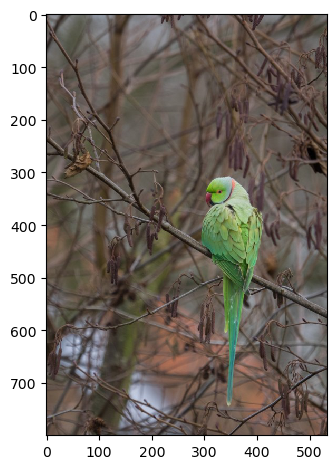

In [4]:
# package imports
import os, glob
import numpy as np
from skimage.io import imread
from skimage.io import imshow

# CHANGE THIS
indir = os.path.expanduser('./datasets/parakeetsNL400images/')
filelist1 = list(glob.iglob(os.path.join(indir, "parakeetsNL_roseringed_images200", "*.jpg")))
filelist2 = list(glob.iglob(os.path.join(indir, "parakeetsNL_otherspecies_images200", "*.jpg")))

# Your code here
print(f'number of roseringed parakeet images: {len(filelist1)}')
print(f'number of other parakeet images: {len(filelist2)}')

img = imread(filelist1[1])
imshow(img)
print(f'shape of numype tensor of the image : {img.shape}')



Next, prepare the dataset for applying classification, *without* loading the image data into memory:

* Create a single Python list that includes the filenames of all the image files to be used, and another list that indicates (with a 1 or 0) whether the image refers to a rose-ringed parakeet.
* Create a train-test split from these lists (you can use sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) -- make sure the data are shuffled, ideally using a fixed random state.

In [5]:
from sklearn.model_selection import train_test_split

# Your code here
filelist = filelist1 + filelist2
filelabels = [1] * len(filelist1) + [0] * len(filelist2)
X_train, X_test, y_train, y_test = train_test_split(filelist, filelabels, test_size = 0.4, random_state = 1)

Next write a function that takes a path to an image file as an argument, and returns the loaded image data, resized to a fixed square size which is passed in as a parameter (default 64). Check that it works.

(64, 64, 3)

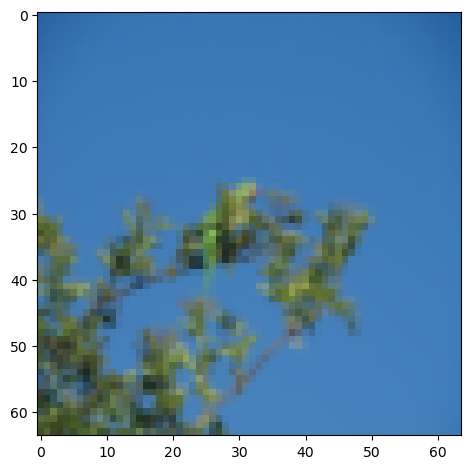

In [6]:
from skimage.io import imread
from skimage.transform import resize
import os

# Your code here
def img_loader(image_path: str, image_size : int = 64):
    image = imread(image_path)
    image_resized = resize(image, (image_size, image_size, 3))
    return image_resized

imshow( img_loader(filelist1[0]) )
img_loader(filelist1[0], 64).shape
    

Lab 3b: training classifiers
---------

Next train an SVM classifier to discriminate between the roseringed and non-roseringed parakeets, directly using the image pixel data (the class is called "SVC" in sklearn).

You can do this by loading the image data into memory as a list/array, using the filename lists you previously prepared. If the images are too big for your computer memory, use a smaller size.

For the SVM we will treat each pixel in the image as a separate feature, so you need to flatten each image array into a vector.

In [7]:
# Loading data
# Your code here

# transform filename to resized image file
for i in range(len(X_train)):
    X_train[i] = img_loader(X_train[i]).flatten()
for i in range(len(X_test)):
    X_test[i] = img_loader(X_test[i]).flatten()
    

In [74]:
from sklearn import metrics, svm
# Training SVM and evaluating its performance
# Your code here

clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)


0.5510204081632653

How good are the results? Are they better than chance? Why / why not? What information is the classifier using?

In [ ]:
Just a bit better than chance level (55.1%)

3c: Classifiers using pretrained embeddings
--

Next, we perform the same task, but using embeddings from [the MegaDetector CNN algorithm](https://github.com/microsoft/CameraTraps).

You can either:

* Use the precomputed embeddings supplied: [**features_megadetector_parakeetsNL.zip**](https://surfdrive.surf.nl/files/index.php/s/rAte09T4DwK15gj) (1.5 GB to download). Or
* Generate the embeddings yourself. In order to do this, you need to have MegaDetector set up correctly, and run it on your images. We provide a python script `md_embedding_extractor.py` to help get an embedding out of the model. Install that file inside the MegaDetector `CameraTraps` code folder.

use the ***same*** train and test splits that you already calculated above. The list of files you calculated gives the paths to the raw files, so you should transform the strings directly to give the pickle file paths (the paths are the same but with a change of folder and file-extension).

Tip: again you will need to resize the image data. However, they are now stored in a shape (index, channel, x, y) so we can't use the skimage `resize()` command. We provide a function below, which loads a pickle and resizes it.

If your computer has memory issues, use a smaller size value when loading. We have already scaled them down to 128x128.

In [76]:
import torch
import torch.nn.functional
import pickle, os

def load_resize_pickled_tensor(inpath, newsize=64):
    with open(inpath, 'rb') as infp:
        t = pickle.load(infp)
    t = torch.tensor(t)
    t = torch.nn.functional.interpolate(t, size=(newsize, newsize))
    t_return = t.numpy()
    del t
    return(t_return)

def fullpath_to_filename(pth):
    "You can use this easily to get the filename"
    return os.path.splitExt(os.path.basename(pth))[0]
    
#test: print(load_resize_pickled_tensor("/home/dans/Documents/tilnat/teaching_planning/ai4ne/datasets/parakeetsNL/features_megadetector_parakeetsNL/0/15062845.pckl").shape)

In [89]:
# To make some space in RAM, it may be wise to forget the raw data we loaded before
# del X_train
# del X_test

# Load the MegaDetector embeddings into memory (remember to flatten each one)
embeddings_indir = os.path.expanduser('./features_megadetector_parakeetsNL/features_megadetector_parakeetsNL/')
embeddings_0_path = os.path.expanduser('./features_megadetector_parakeetsNL/features_megadetector_parakeetsNL/0/')
embeddings_1_path = os.path.expanduser('./features_megadetector_parakeetsNL/features_megadetector_parakeetsNL/1/')

filelist_e0 = list(glob.iglob(os.path.join(embeddings_indir, "0", "*.pckl")))
filelist_e1 = list(glob.iglob(os.path.join(embeddings_indir, "1", "*.pckl")))

filelist_e = filelist_e0 + filelist_e1
filelabel_e = [0] * len(filelist_e0) + [1] * len(filelist_e1)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(filelist_e, filelabel_e, test_size = 0.4, random_state = 1)

for i in range(len(X_train_e)):
    X_train_e[i] = load_resize_pickled_tensor(X_train_e[i], newsize=64).flatten()
for i in range(len(X_test_e)):
    X_test_e[i] = load_resize_pickled_tensor(X_test_e[i], newsize=64).flatten()


# Your code here



In [90]:
# Training and evaluating an SVM using MegaDetector embeddings

# Your code here

clf = svm.SVC()
clf.fit(X_train_e, y_train_e)
y_pred_e = clf.predict(X_test_e)
metrics.accuracy_score(y_test_e, y_pred_e)


0.5238095238095238

Now for **both** of your classifiers, inspect the error cases, i.e. the images with the wrong decision. To do this, you will need to compare the groundtruth against predictions, and find a way to display the mis-matches, either directly in the notebook or in a file window.

The **mis-matches** are, of course, the items where the true label `y_test` doesn't match the prediction `my_ml_model.predict(X_test)`.

What can you determine about the issues that cause misclassifications for the two?

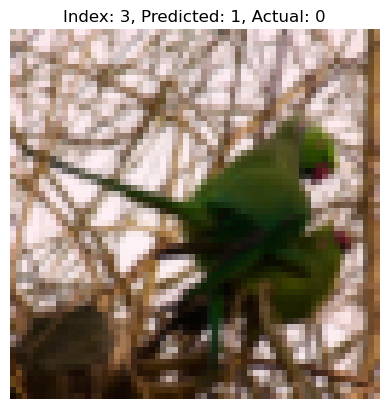

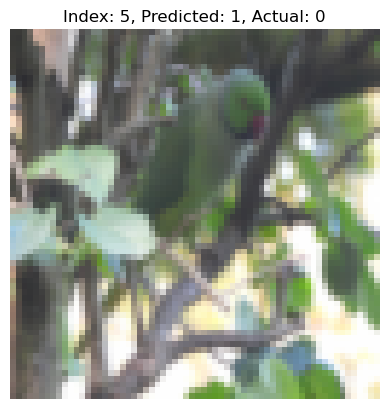

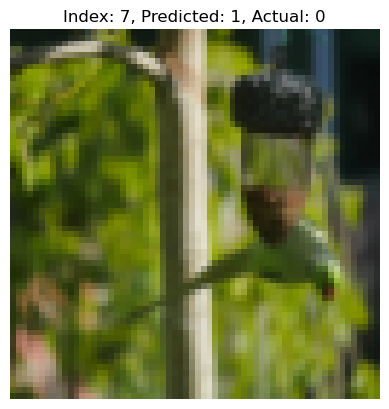

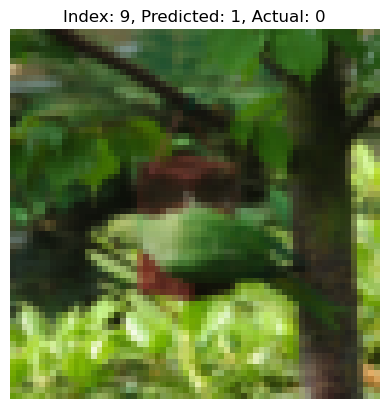

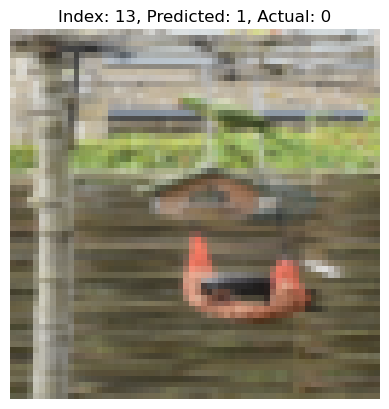

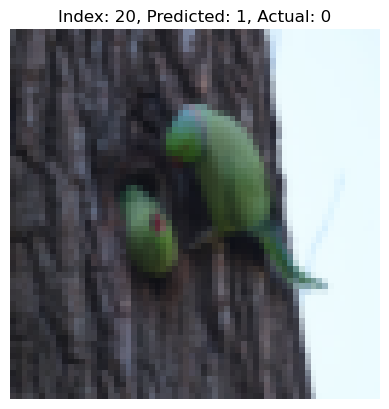

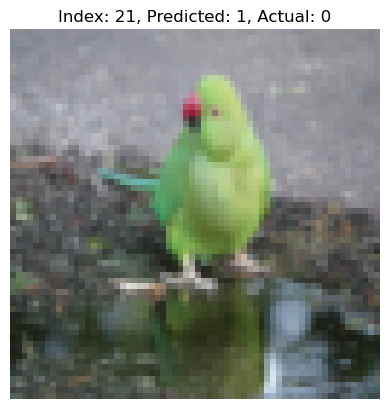

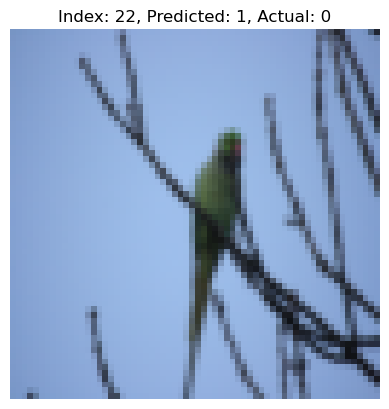

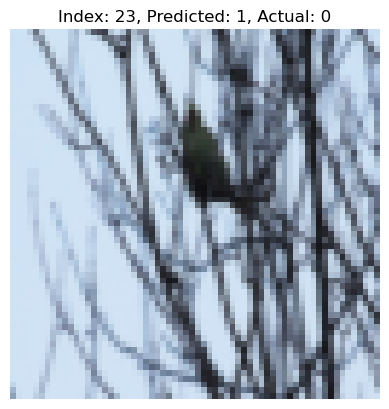

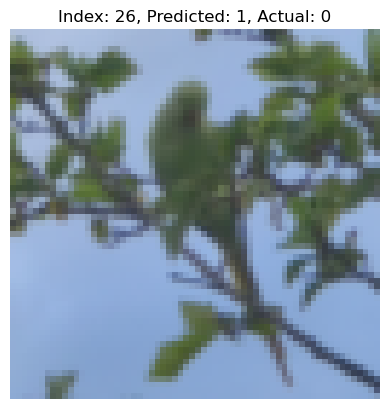

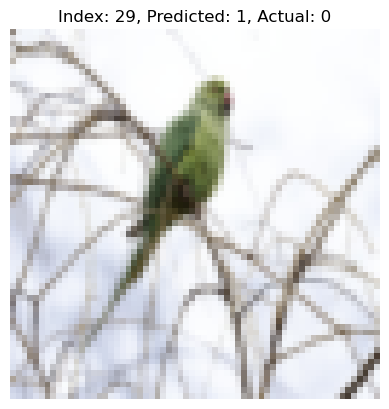

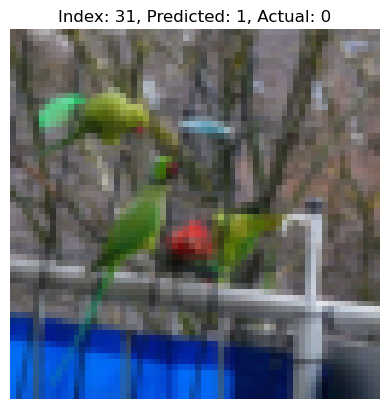

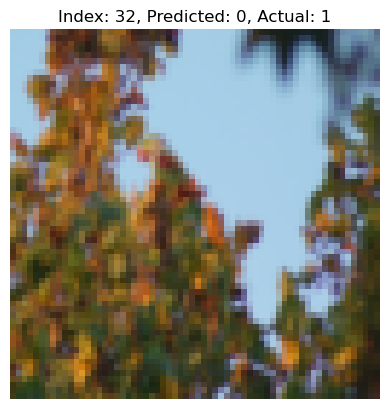

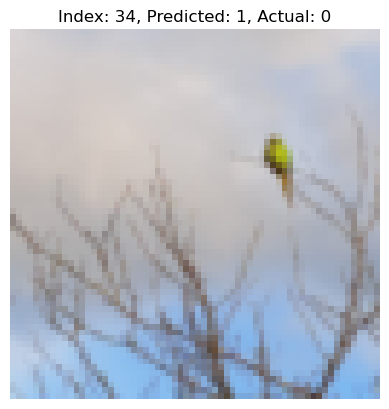

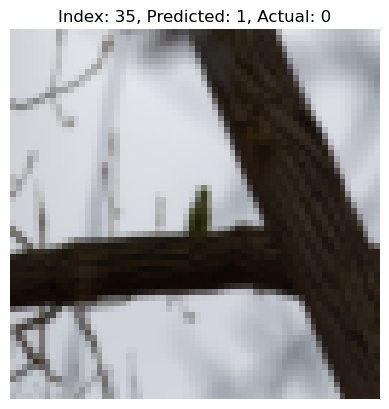

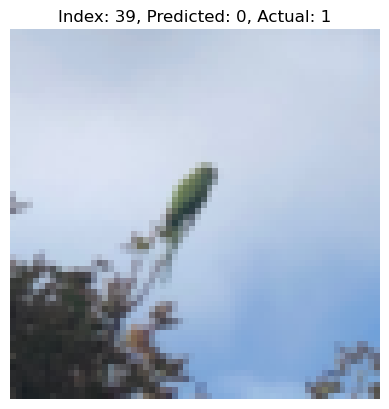

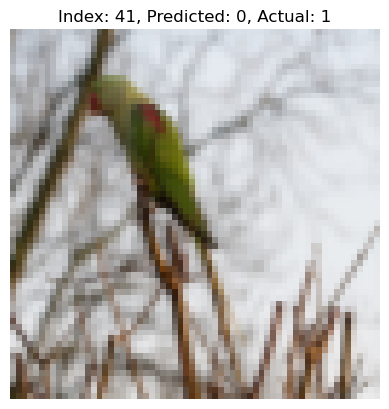

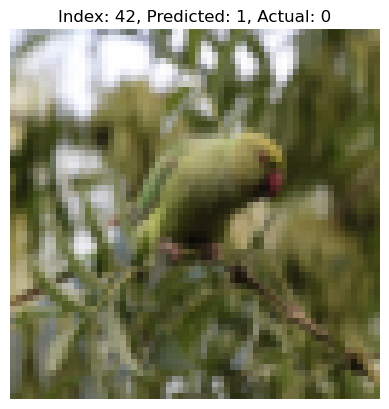

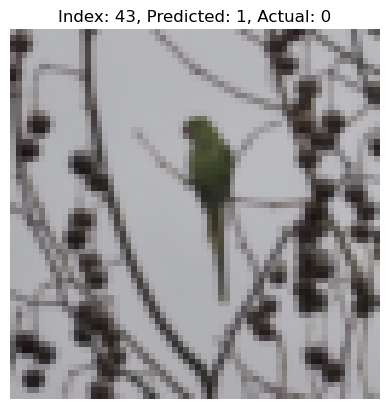

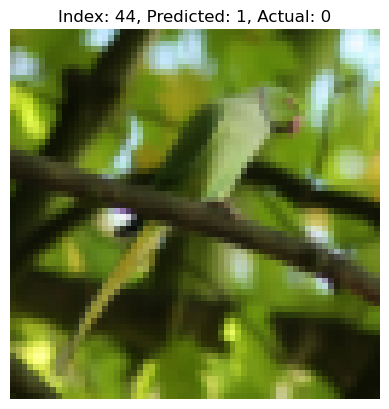

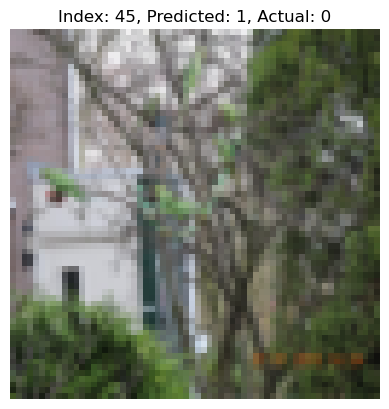

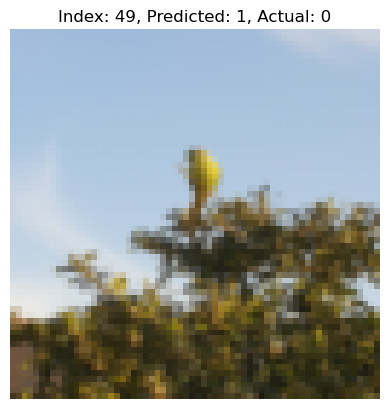

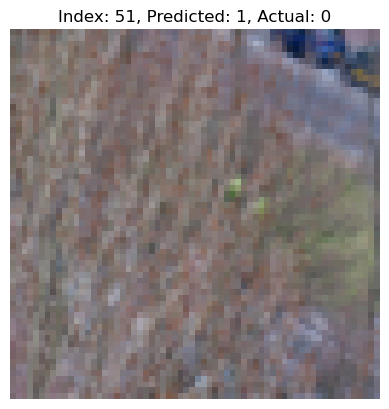

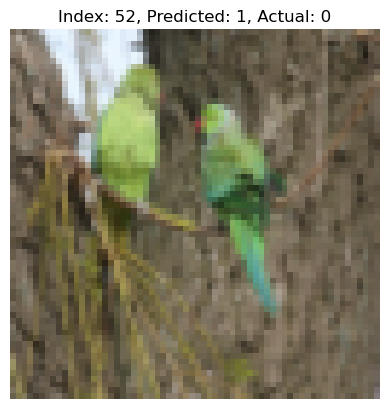

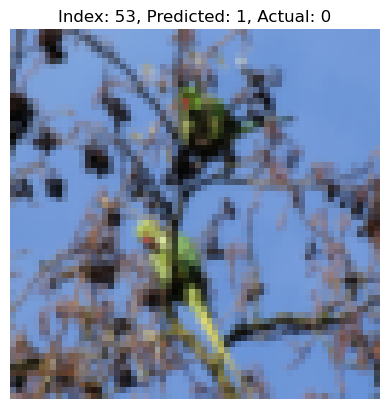

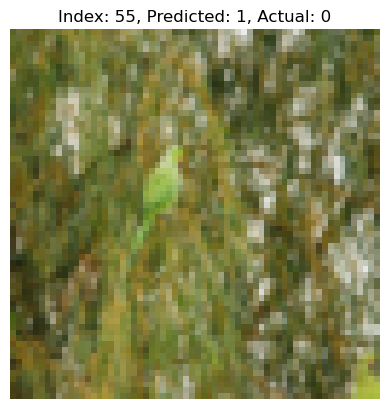

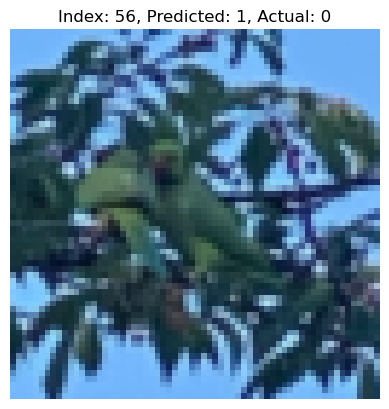

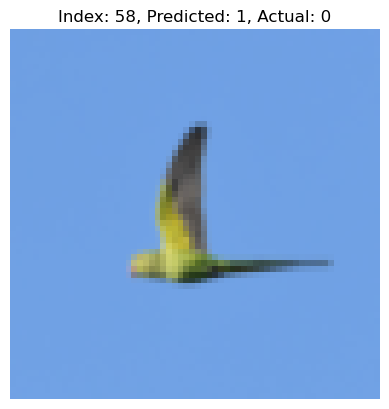

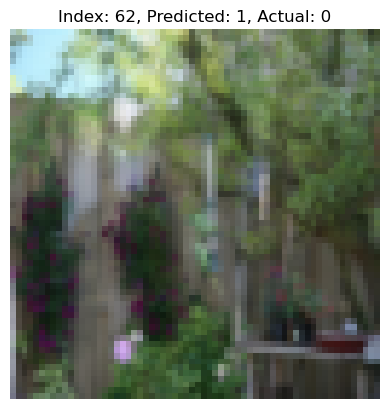

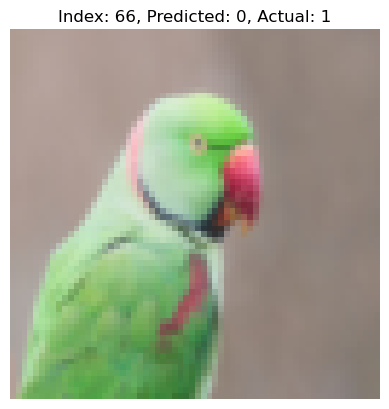

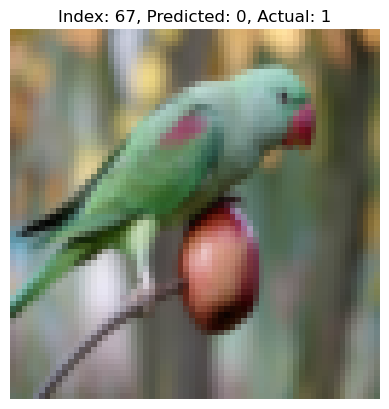

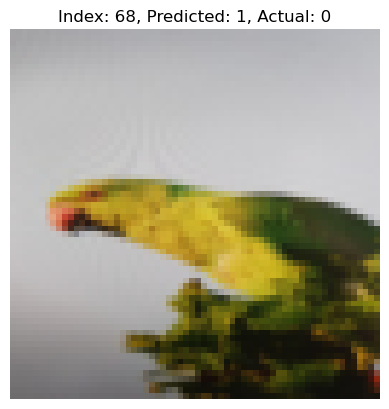

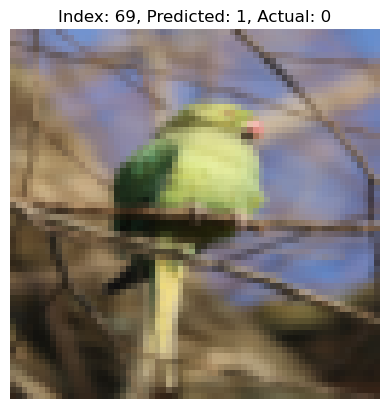

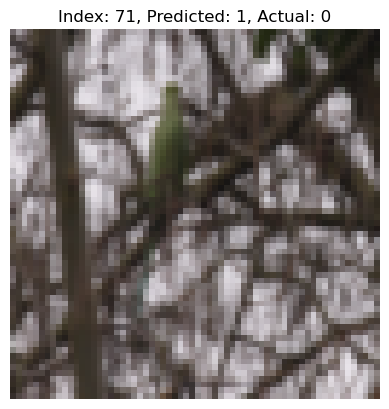

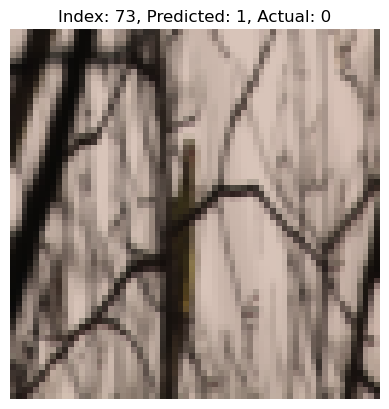

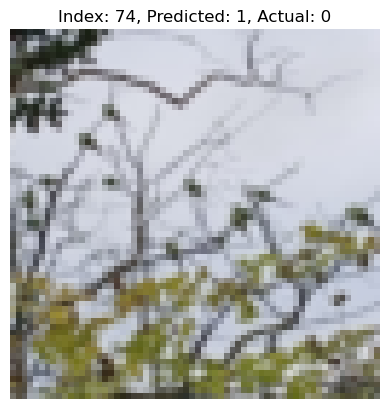

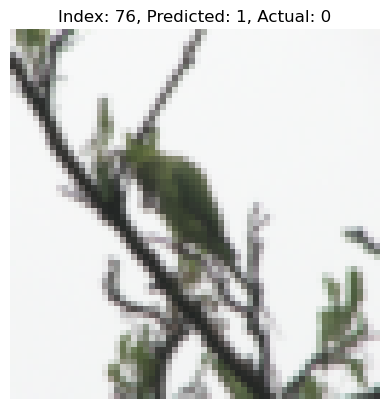

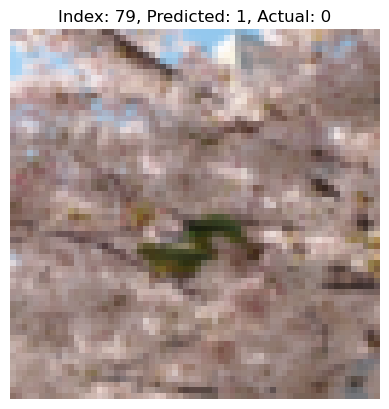

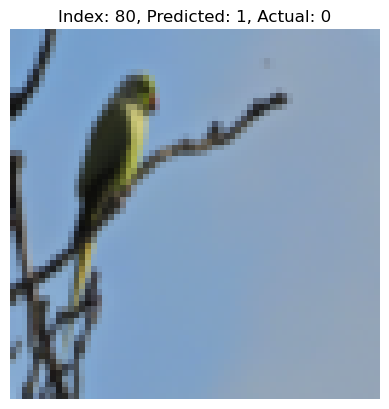

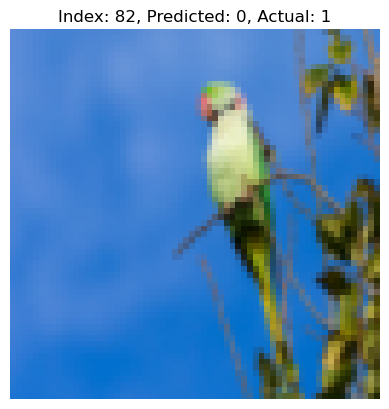

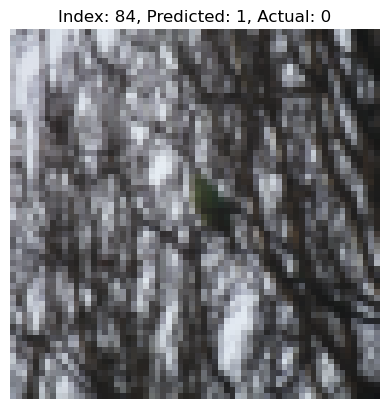

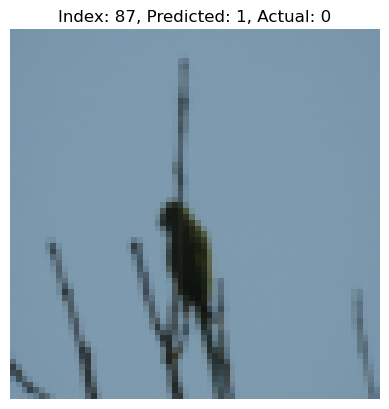

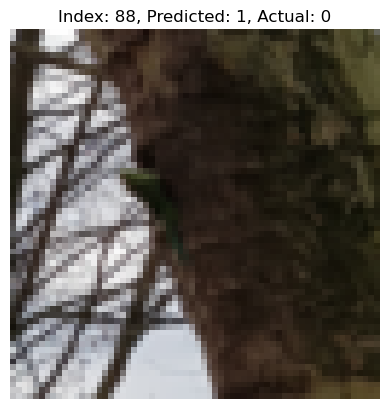

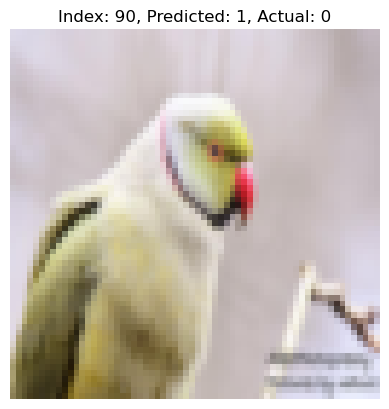

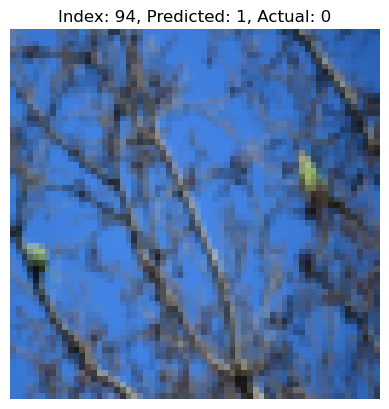

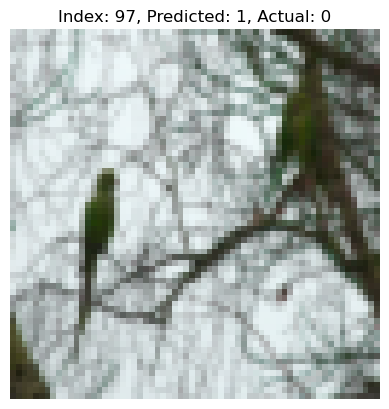

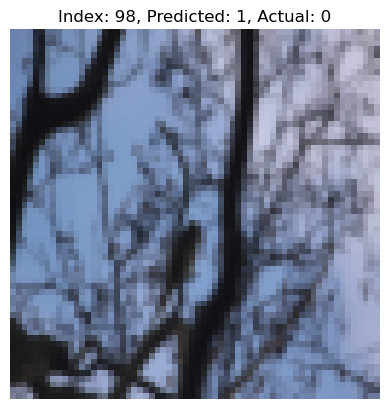

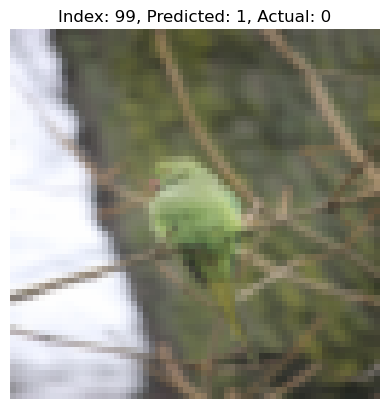

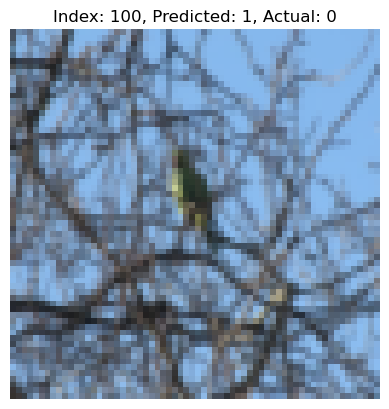

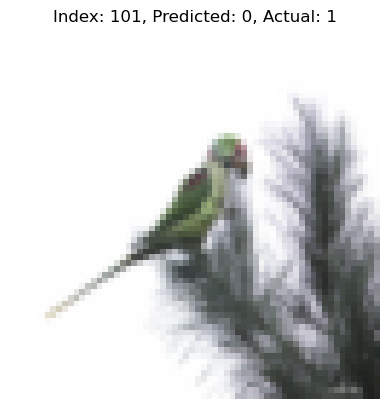

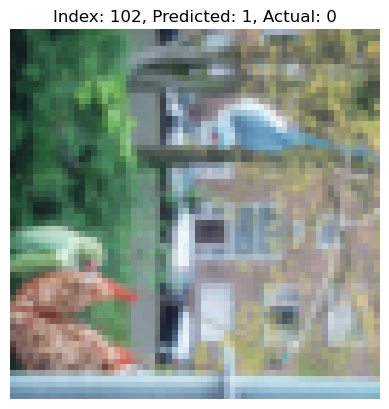

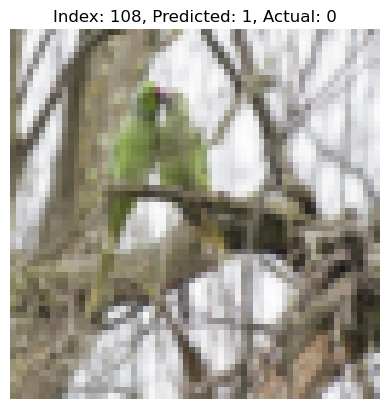

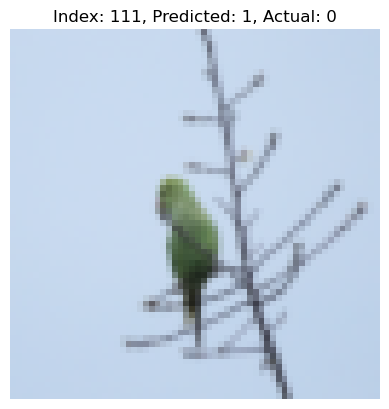

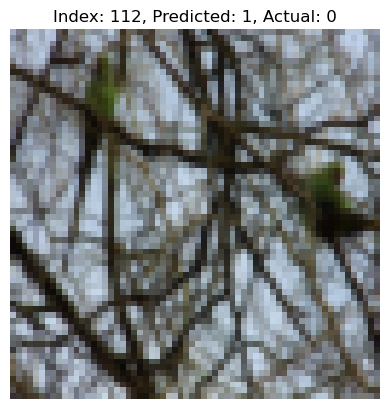

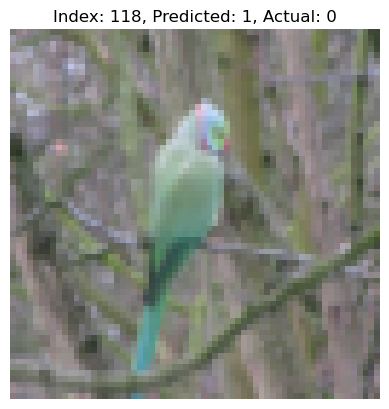

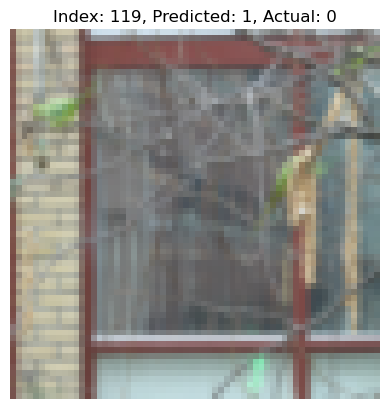

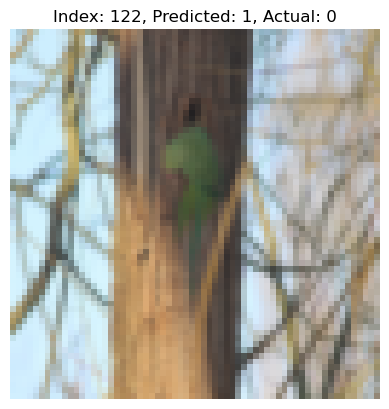

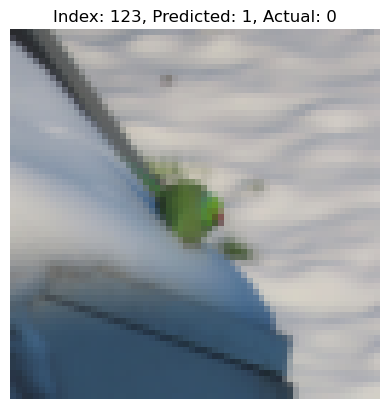

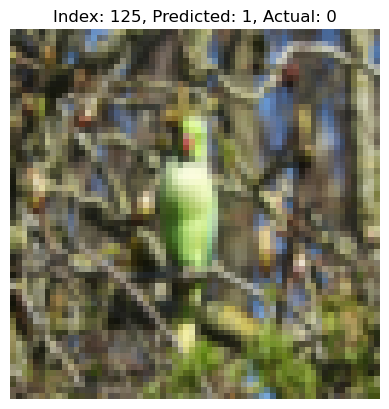

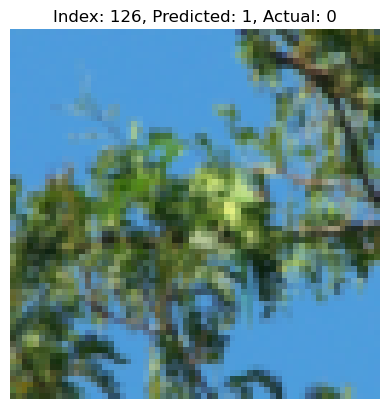

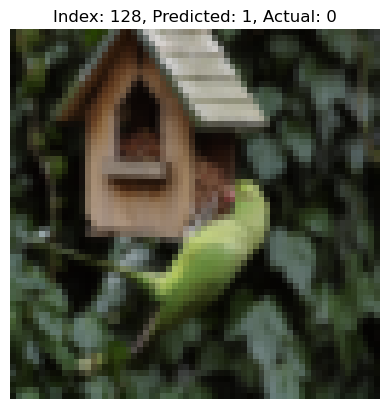

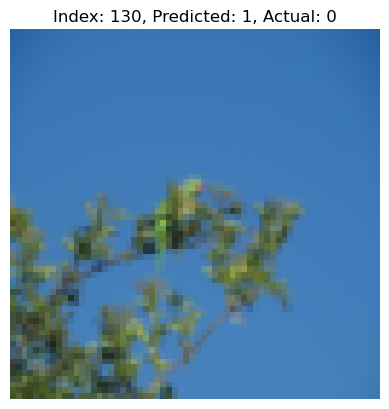

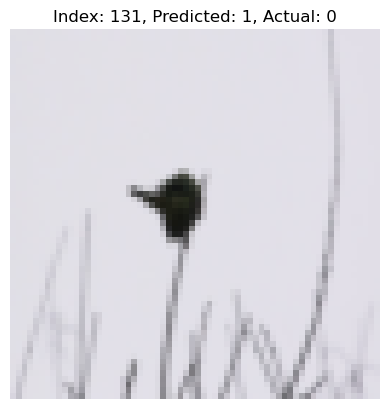

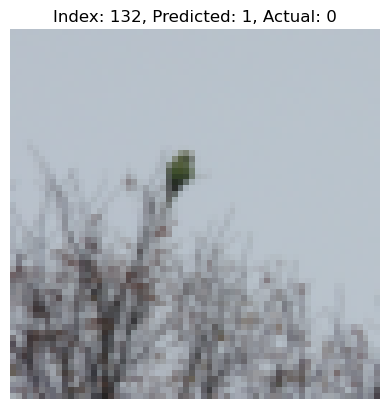

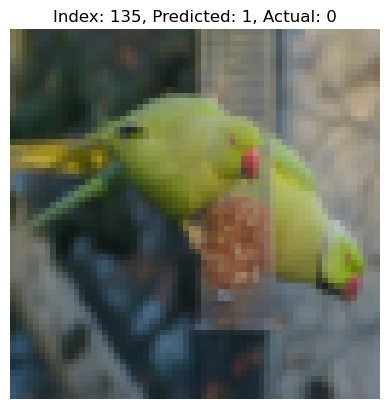

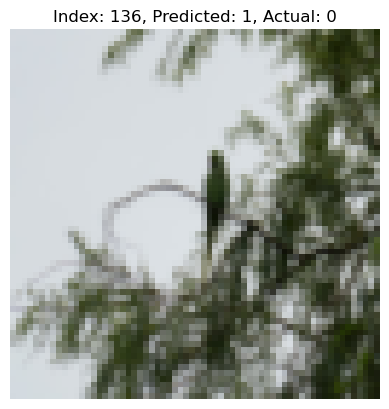

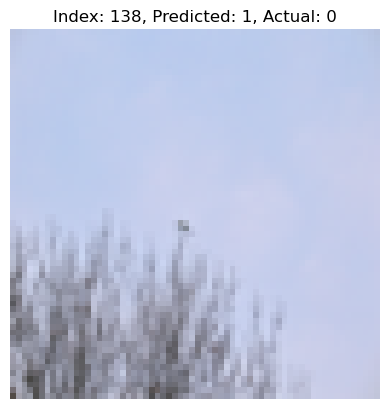

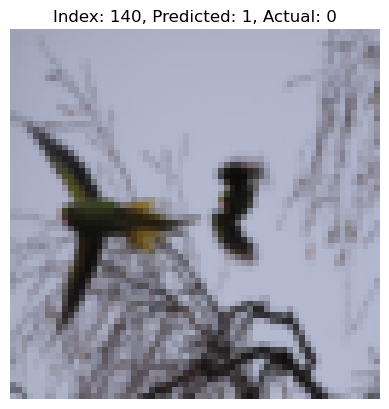

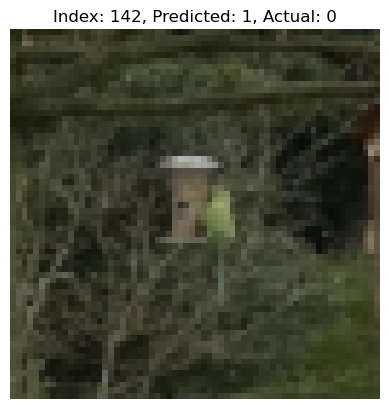

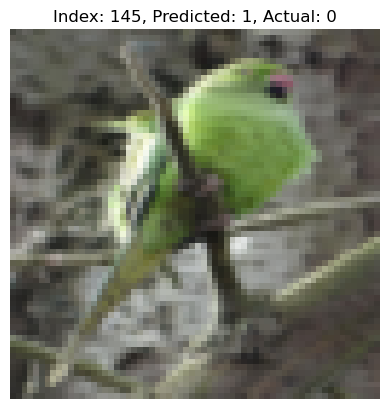

In [99]:
# Your code here
for i in range(len(y_pred_e)):
    if y_pred_e[i] != y_test_e[i]:
        plt.figure()
        plt.imshow(img_loader(X_test[i]), cmap='gray')  # Ensure the correct color map
        plt.title(f'Index: {i}, Predicted: {y_pred_e[i]}, Actual: {y_test_e[i]}')
        plt.axis('off')  # Hide the axes
        plt.show()


Lab 3d: CNN
---------------

We will train a CNN to make a binary decision about whether or not there is a rose-ringed parakeet in any given image.

* Train a simple CNN over the image data. You can use Pytorch or Pytorch Lightning for this. You can choose your CNN type, but I suggest a [mobilenet_v3_small](https://pytorch.org/vision/master/models/generated/torchvision.models.mobilenet_v3_small.html) base model, or any simple CNN with not many layers (e.g. 3 convolutional layers). To save time, use a small fixed number of training epochs (e.g. 10 epochs).

For the above, use a Pytorch Lightning tutorial, BUT remember you don't want to use their dataset, instead we want to use our `load_resize_pickled_tensor()` function. For training the CNN, we *don't* load all the data into memory. Instead, we implement a DataLoader that will progressively read the data as needed.

* As before -- calculate the algorithm's accuracy, using the test set.

* As before -- inspect the error cases, i.e. the images with the wrong decision. What can you determine?

We would like to train an algorithm, based on the features extracted from MegaDetector, to make a binary decision about whether or not there is a parakeet in any given image.

* Write a function to extract SPATIALLY POOLED embedding values for each image. In other words, extract the embedding from MegaDetector but then collapse the x and y dimensions (e.g. using mean or max, or something else...) so that for each image you have a simple 80-dimensional representation. (80 is the number of channels in the detector.)

* Now use scikit-learn to train an algorithm using these features. You could use [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), or something else.

* Calculate the algorithm's accuracy, using the test set.

* Inspect the error cases, i.e. the images with the wrong decision. What can you determine?

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 4

OPTIONAL EXTRA: Next, instead of pooling the embeddings, use them as-is and train a simple CNN over the (80,X,Y )-dimensional data. You can use Pytorch Lightning for this, and the code can be separate from MegaDetector. Analyse the outcome of this the same way as the others.

In [ ]:
import torch
import torch.nn.functional
import pickle, os

# Your code here
